<a href="https://colab.research.google.com/github/royam0820/LLM_OCR/blob/main/amr_5_RAG_multiple_md_files.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This notebook demonstrates how to build a Retrieval-Augmented Generation (RAG) system using LangChain, FAISS, and Markdown (.md) documents with embedded image references.

Specifically, we:

📂 Load Markdown files (and their corresponding images) exported from an OCR pipeline.

🧠 Embed the textual content using OpenAI embeddings.

🗃️ Store the embedded chunks in a FAISS vector store for fast similarity search.

🔍 Perform natural language queries over the content, retrieving relevant text and figures (e.g., "Figure 1").

This setup enables a rich and interactive Q&A experience over structured OCR content, especially useful for scientific or technical reports that include visual figures.



## Batch Process for Ocr Output to use in a RAG System

How it works in detail:

**extract_image_paths_from_md**:
Uses a regex to find lines like ![some alt text](images/2101.03961v3_img_1.jpeg) and returns fully qualified paths by combining the subfolder path with the filename. If the Markdown image link is a URL (http...), it’s returned unchanged.

**load_md_documents**:
Iterates through each subfolder (like 2101.03961v3), looks for .md files (like output.md), reads the text, and extracts the images. Everything is then wrapped into a LangChain Document object with metadata including image paths.

**build_vectorstore**:
Splits the text into chunks and stores them in a FAISS index. Each chunk retains the metadata field with image references.

**query_vectorstore**:
Performs a similarity search against the stored chunks, returning the top k matches. You can then access the chunk’s text and associated image paths in the results’ metadata.

With this setup, you can handle multiple .md files plus their corresponding images in a consistent, queryable RAG pipeline.


DIRECTORY STRUCTURE AFTER OCR
/content/drive/MyDrive/OCR/Documents/ocr_output

Each subfolder (named after the PDF identifier) has:

The main text extracted to output.md.

The raw OCR JSON (ocr_response.json).

A subfolder images/ containing any images referenced in the document.

This keeps all content for one document self-contained while still making it straightforward to iterate over multiple documents.

```
ocr_output/
  2101.03961v3/
    output.md
    ocr_response.json
    images/
      2101.03961v3_img_1.jpeg
      2101.03961v3_img_2.jpeg
      ...
  1804.07821v1/
    output.md
    ocr_response.json
    images/
      1804.07821v1_img_1.jpeg
      1804.07821v1_img_2.jpeg
      ...
  2402.03300v3/
    output.md
    ocr_response.json
    images/
      2402.03300v3_img_1.jpeg
      2402.03300v3_img_2.jpeg
      ...
  ...
```



Inline images in the markdown (.md) file are referenced as follows:
- Main directory: `/content/drive/MyDrive/OCR/Documents/ocr_output``
- Sub-directory: `
/1804.07821v1`
- markdown document: `output.md`
- inline image:  `![[1804.07821v1_img_1.jpeg]]`



## Setup

In [1]:
!pip -q install langchain langchain-community openai faiss-cpu unstructured tiktoken pillow clip-interrogator sentence-transformers transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 38.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 787.8/787.8 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.7 MB/s eta 0:00:00
   ━━

In [2]:
# Imports a display helper from IPython to show images directly in notebook cells
from IPython.display import Image, display

In [5]:
# Calling the OpenAI API Key
import os
from google.colab import userdata

api_key = os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')


In [6]:
if api_key is not None:
    print("API key is exported and available.")
else:
    print("API key is not exported or is empty.")

API key is exported and available.


In [7]:
# Standard Python libraries
import os           # For accessing environment variables and file system operations
import textwrap     # For formatting text output (e.g., wrapping lines)
import re           # For working with regular expressions, useful for text cleaning or parsing

# LangChain components for Retrieval-Augmented Generation (RAG)
from langchain.embeddings import OpenAIEmbeddings  # Converts text into numerical embeddings using OpenAI
from langchain.chains import RetrievalQA           # Combines retrieval with question-answering logic
from langchain.text_splitter import RecursiveCharacterTextSplitter  # Splits large text into manageable chunks
from langchain.docstore.document import Document   # Data structure for holding and passing around text documents
from langchain.vectorstores import FAISS           # Vector store to index and search embedded text efficiently


## Extract images from md files

In [8]:
# Extract Image Paths from Markdown Text
def extract_image_paths_from_md(md_text, images_subfolder):
    """
    Finds all Markdown image references in the form ![[filename]].
    Returns a list of absolute image paths for local files or unchanged URLs.
    """
    # Regular expression pattern to find ![[filename]]-style image tags in Markdown
    pattern = r'!\[\[(.*?)\]\]'  # Captures filename inside double brackets
    matches = re.findall(pattern, md_text)
    image_paths = []
    for match in matches:
        # If the match is a URL, keep it as-is
        if match.startswith("http"):
            image_paths.append(match)
        else:
            # Otherwise, assume it's a local image file and prepend the image subfolder path
            full_path = os.path.join(images_subfolder, match)
            image_paths.append(full_path)
    return image_paths

In [9]:
# Adjust this path to your actual location:
ocr_output_path = "/content/drive/MyDrive/OCR/Documents/ocr_output"

## Loading md documents and associated images

In [10]:
# Loading Markdown Documents and Associated Images
def load_md_documents(ocr_output_path):
    """
    Recursively scans the ocr_output directory for .md files and extracts images.
    """
    docs = []   # Initialize a list to hold the loaded Document objects

    # Scan through each entry (file or folder) in the root OCR output path
    for entry in os.scandir(ocr_output_path):
        if entry.is_dir():
            subfolder = entry.path
            images_subfolder = os.path.join(subfolder, "images")

            # Look for Markdown files inside the subfolder
            for filename in os.listdir(subfolder):
                if filename.endswith(".md"):
                    md_path = os.path.join(subfolder, filename)

                    # Read the Markdown file contents
                    with open(md_path, "r", encoding="utf-8") as f:
                        text = f.read()

                    # Extract embedded image paths using custom function
                    image_paths = extract_image_paths_from_md(text, images_subfolder)

                    # Debugging output to inspect what's being processed
                    print(f"Processing {md_path}")
                    print("Extracted image paths:", image_paths)

                    # Optional check: See if each referenced image file actually exists
                    for img_path in image_paths:
                        if os.path.exists(img_path):
                            print(f"Image exists: {img_path}")
                        else:
                            print(f"Image missing: {img_path}")

                    # Create a LangChain Document with the text and metadata (image paths and source folder)
                    doc = Document(
                        page_content=text,
                        metadata={
                            "source": subfolder,
                            "images": image_paths
                        }
                    )
                    docs.append(doc)
    return docs


In [11]:
 # 1. Load all .md documents + associated image paths
 docs = load_md_documents(ocr_output_path)

Processing /content/drive/MyDrive/OCR/Documents/ocr_output/2101.03961v3/output.md
Extracted image paths: ['/content/drive/MyDrive/OCR/Documents/ocr_output/2101.03961v3/images/2101.03961v3_img_1.jpeg', '/content/drive/MyDrive/OCR/Documents/ocr_output/2101.03961v3/images/2101.03961v3_img_2.jpeg', '/content/drive/MyDrive/OCR/Documents/ocr_output/2101.03961v3/images/2101.03961v3_img_3.jpeg', '/content/drive/MyDrive/OCR/Documents/ocr_output/2101.03961v3/images/2101.03961v3_img_4.jpeg', '/content/drive/MyDrive/OCR/Documents/ocr_output/2101.03961v3/images/2101.03961v3_img_5.jpeg', '/content/drive/MyDrive/OCR/Documents/ocr_output/2101.03961v3/images/2101.03961v3_img_6.jpeg', '/content/drive/MyDrive/OCR/Documents/ocr_output/2101.03961v3/images/2101.03961v3_img_7.jpeg', '/content/drive/MyDrive/OCR/Documents/ocr_output/2101.03961v3/images/2101.03961v3_img_8.jpeg', '/content/drive/MyDrive/OCR/Documents/ocr_output/2101.03961v3/images/2101.03961v3_img_9.jpeg', '/content/drive/MyDrive/OCR/Documents/o

## Build VectorStore

In [12]:
# Building a Vector Store from Markdown Documents
def build_vectorstore(docs, embedding_model=None):
    """
    Splits documents into chunks, embeds them, and stores them in a FAISS index.
    """
    # Use the default OpenAI embedding model if none is provided
    if embedding_model is None:
        embedding_model = OpenAIEmbeddings()

    # Initialize a text splitter to break documents into overlapping chunks
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200
    )

    chunked_docs = []
    # Go through each document and split its content into chunks
    for doc in docs:
        chunks = text_splitter.split_text(doc.page_content)
        # Re-wrap each chunk into a Document object, preserving the original metadata
        for chunk in chunks:
            chunked_docs.append(
                Document(page_content=chunk, metadata=doc.metadata)
            )
    # Convert all chunks into embeddings and store them in a FAISS vector database
    vectorstore = FAISS.from_documents(chunked_docs, embedding_model)
    return vectorstore

In [13]:
# 2. Build VectorStore
vectorstore = build_vectorstore(docs)

<ipython-input-12-147c8a8cd286>:8: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding_model = OpenAIEmbeddings()


## Query VectorStore

In [14]:
# Query Vector Store and Display Figures - user_query = "show me figure 1 in this document"
def query_vectorstore_and_show_figure(vectorstore, query, figure_number=None, k=3):
    """
    Queries the vector store and optionally displays a specific figure.
    If figure_number is provided (e.g., '1' for 'Figure 1'), attempts to find and display it.
    """
    # Perform semantic similarity search on the vectorstore
    results = vectorstore.similarity_search(query, k=k)

    # Loop through the top results and display text and image metadata
    for i, res in enumerate(results, start=1):
        print(f"--- Result {i} ---")
        print("Text chunk:", res.page_content[:300], "...")
        print("Source folder:", res.metadata["source"])

        # Check if the chunk includes any images in its metadata
        if "images" in res.metadata and res.metadata["images"]:
            if figure_number:
                # If a specific figure is requested (e.g., "Figure 2"), look for it in the text
                figure_text = f"Figure {figure_number}"
                if figure_text in res.page_content:
                    # For simplicity, display the first image in metadata (adjust if multiple images)
                    img_path = res.metadata["images"][0]  # Assuming first image is Figure 1
                    try:
                        print(f"Displaying {figure_text}:")
                        display(Image(filename=img_path))
                    except Exception as e:
                        print("Error displaying", img_path, ":", e)
                else:
                    print(f"{figure_text} not mentioned in this chunk")
            else:
                # No specific figure requested — display all images associated with this chunk
                for img_path in res.metadata["images"]:
                    try:
                        display(Image(filename=img_path))
                    except Exception as e:
                        print("Error displaying", img_path, ":", e)
        else:
            print("No images available")
        print()

## Exemple Query

--- Result 1 ---
Text chunk: Figure 1. Fully convolutional architecture diagram (not to scale). Arrows show separate columns that all take the same input. At the end of the columns, the feature maps are merged (concatenated) together and passed to another series of dilated convolutions: the aggregator, which can aggregate the m ...
Source folder: /content/drive/MyDrive/OCR/Documents/ocr_output/1804.07821v1
Displaying Figure 1:


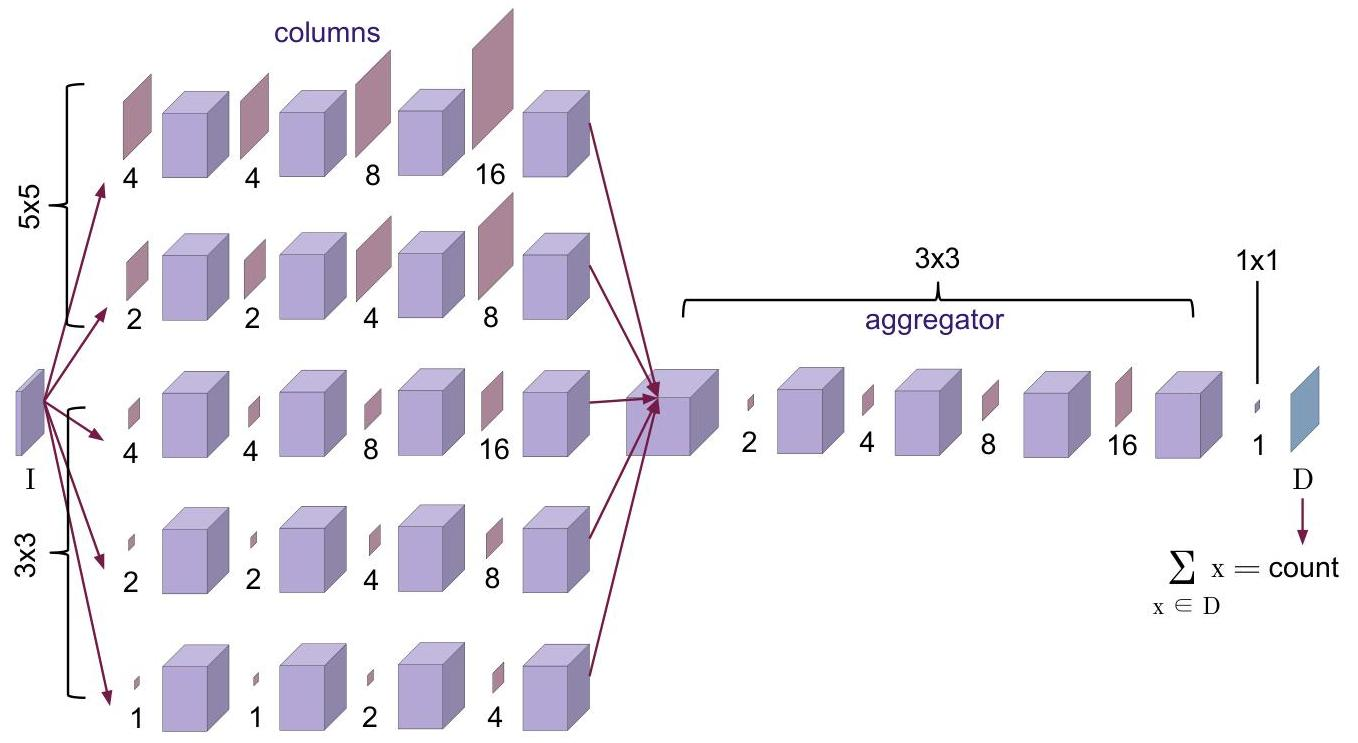


--- Result 2 ---
Text chunk: The network as shown in Figure 1 contains 5 columns. Note that dilations allow us to use more columns for counting than [28] or [8]. Each column looks at a larger scale than the previous (the exact dilations can also be seen in Figure 1). There are 32 feature maps for each convolution, and all input ...
Source folder: /content/drive/MyDrive/OCR/Documents/ocr_output/1804.07821v1
Displaying Figure 1:


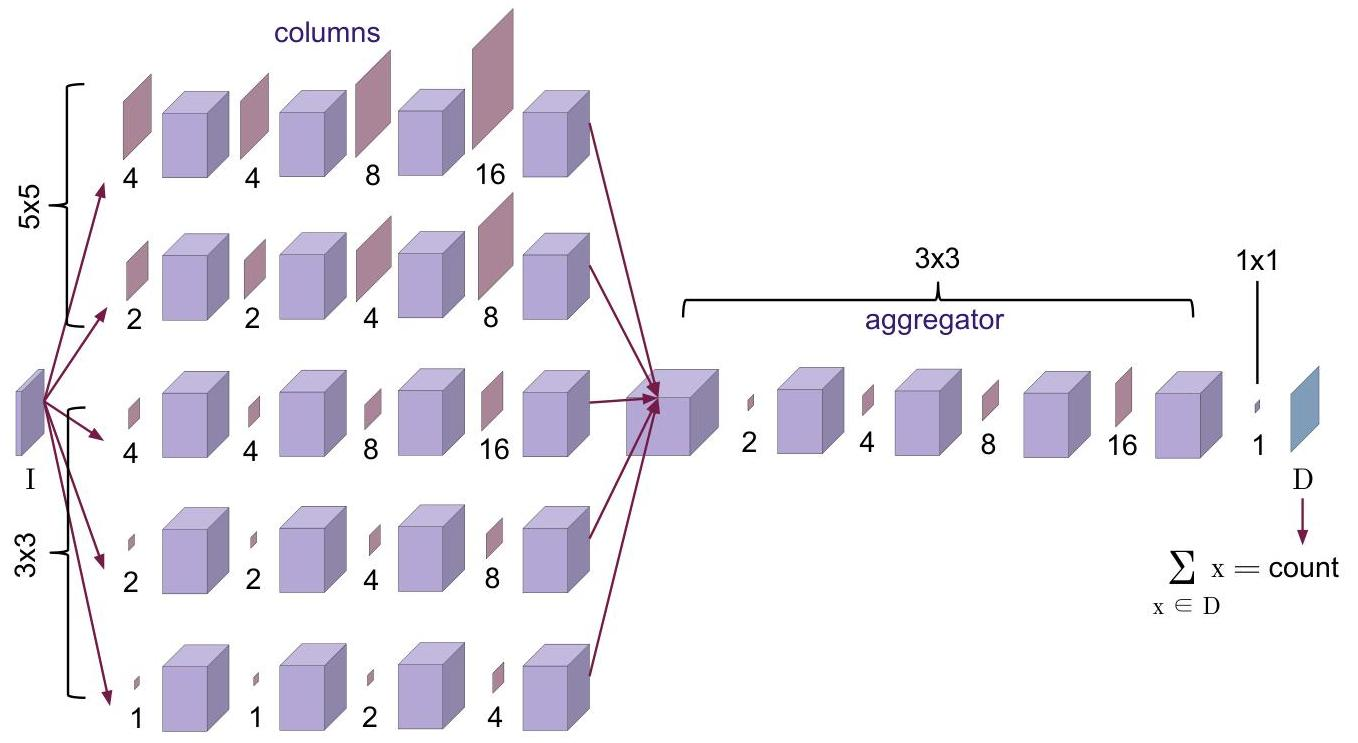


--- Result 3 ---
Text chunk: These issues are addressed by the work of [18]. Rubio et al. show that a fully convolutional neural network can be used to produce a supervised regressor that produces density maps as in [15]. They further demonstrate a method dubbed HydraCNN which essentially combines multiple convolutional network ...
Source folder: /content/drive/MyDrive/OCR/Documents/ocr_output/1804.07821v1
Figure 1 not mentioned in this chunk



In [15]:
# Query Vector Store and Display Figures - user_query = "show me figure 1 in this document"
user_query = "show me the Figure 1. Fully convolutional architecture diagram"
figure_number = "1"  # Extracted from query; could parse dynamically
query_vectorstore_and_show_figure(vectorstore, user_query, figure_number)

# Summary

In this notebook, we successfully built an end-to-end RAG pipeline tailored for Markdown documents with embedded images:

✅ Extracted image paths from Markdown syntax (![[image.png]])

✅ Loaded and wrapped content as LangChain Document objects

✅ Chunked documents and created embeddings using OpenAIEmbeddings

✅ Stored and searched those embeddings efficiently using FAISS

✅ Queried the vector store and dynamically displayed relevant figures

This pipeline enables advanced document exploration — combining semantic understanding of text with visual grounding via referenced images. It is a powerful tool for document-centric AI assistants, technical knowledge bases, and OCR-driven research workflows.

